In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import glob as glob
import re 
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from array import *
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.optimize import curve_fit

# Tools for analysis resonances

## Response to pulse

In [2]:
#search for filenames
file_names = glob.glob("18.02.2021/*.dat")

file_names = file_names
file_names

[]

In [3]:
#function for reading of the current fom the file name. 
#The pattern Curr_***_uA, where *** is the current value
def get_curr(file_name):
    current_deg_ex = re.compile(r'Curr_(-)*\d(\d)?(\d)?(\d)?(\d)?_uA')
    current_val = current_deg_ex.search(file_name)
    current_val_float = float(current_val.group().split('_')[1])
    return current_val_float

def complex_lorentz(f,f_0, A,gamma, phi):
    return A*np.exp(1j*phi)*(gamma-1j*(f-f_0))/(gamma**2+(f-f_0)**2)

def vec_model(f,f_0, A,gamma, phi):
    real_part = np.real(complex_lorentz(f,f_0, A,gamma, phi))
    imag_part = np.imag(complex_lorentz(f,f_0, A,gamma, phi))  
    return np.hstack([real_part,imag_part])
def sine_mod(t,f,A,phi, gamma):
    return A*np.sin(2*np.pi*t+phi)*np.exp(-gamma*t)

# class with the main functions needed for data analysis
class FID_out:
    # initialisation of the class with file name only
    def __init__(self,file_name):
        self.file_name = file_name
        self.curr = get_curr(file_name)
    # loading data
    def load_data(self):
        self.data = np.loadtxt(self.file_name)
        
    # computing fft and freq (only the output is the positive-freq part of the douple-side fft)
    def comp_fft(self,a, b):
        self.fft = np.fft.rfft(self.data[a:b,1]) # rfft is fft of real input, the output is only for freq > 0
        self.freq = np.fft.rfftfreq(len(self.fft),self.data[1,0]-self.data[0,0])
        self.sig = self.data[a:b, 1]
        self.time = self.data[a:b, 0]
        #self.fft = self.fft[np.where(self.freq>=0)]
        #self.freq = self.freq[np.where(self.freq>=0)]
        
    # saving the fft to npy file
    def save_fft(self, directory = ''):
        np.save(self.file_name+'_FFT', np.array([self.freq,self.fft]))
    # loading the fft from the npy file
    def load_fft(self):
            x = np.load(self.file_name+'_FFT.npy')
            self.fft = x[1]
            self.freq = np.real(x[0])
    # the funtion allows to find the indexes for the desired frequnecy range
    def find_ind(self, f_min = 0.1,f_max = 10):
        ind_1 = np.where(self.freq >= f_min)
        ind_2 = np.where(self.freq <= f_max)
        self.ind = np.intersect1d(ind_1,ind_2)
    # fitting of the complex lorentzian
    def lorentzian_fit(self,f = 1, A = 1e4, gamma = 1e-3,phi = 0):
        fft = self.fft[self.ind]
        self.fft_fit = fft
        r = np.abs(fft)
        freq = self.freq[self.ind]
        self.freq_fit = freq
        meas_real = np.real(fft)
        meas_imag = np.imag(fft)
        meas = np.hstack([meas_real,meas_imag])
        ind_max = np.where(r == np.max(r))
        A_guess = r[ind_max][0]
        f_guess = np.abs(freq[ind_max])[0]
        phi_guess = phi
        gamma_guess = np.abs( freq[meas_imag.argmax()] - freq[meas_imag.argmin()] )
        popt, pcov = curve_fit(vec_model,freq,meas, p0 = [f_guess,A,gamma_guess,phi_guess])
        self.fit_opt = popt
        self.cov = pcov
        self.t2_s = 1/popt[2]
        self.t2_min = (1/(60*popt[2]))
        return popt, pcov
    

In [9]:
class NG_FID_scan:
    def __init__(self,direct):
        self.directory = direct
    def read_files(self, direct = '', show_files = 'False'):
        self.file_names = np.array(glob.glob(self.directory+direct+"*.dat"))
        if show_files == 'True':
            print(self.file_names)
    def sort_names(self):
        currs = []
        for fn in self.file_names:
            x = FID_out(fn)
            currs.append(x.curr)
        currs = np.array(currs)
        inds = np.argsort(currs)
        self.file_names = self.file_names[inds]
        self.currs = currs[inds]
        
    def fit_FID(self,
                i = 0, 
                show_curr = 'False',
                show_fit_width = 'False', 
                show_plots = 'False',
                a = 101, 
                b = -1, 
                phi = 0,
                gamma = 0.01,
                phase_guessing = 'True',
                f_min = 0.1,
                f_max = 40):
        x = FID_out(self.file_names[i])
        if show_curr == 'True':
            print(x.curr)
            
        x.load_data()
        x.comp_fft(a = a, b = b)
        x.find_ind(f_min = f_min,f_max = f_max)
        c = x.curr
        ind_max = np.where(np.abs(x.fft) == np.max(np.abs(x.fft)) )
        f_guess = x.freq[ind_max]
        if phase_guessing == 'True':
            phase_guess = np.angle(x.fft[ind_max])
        else:
            phase_guess = phi
        popt, pcov = x.lorentzian_fit(phi = phase_guess, gamma = gamma)
        
        if show_fit_width == 'True':
            print('He res width = ', popt[2])
        if show_plots == 'True':
            plt.plot(x.freq_fit,np.abs(x.fft_fit))
            plt.plot(x.freq_fit,np.real(x.fft_fit))
            plt.plot(x.freq_fit,np.imag(x.fft_fit))
            plt.plot(x.freq_fit,np.abs(complex_lorentz(x.freq_fit,*popt)))
            plt.show()
        return popt, pcov, c

    def fit_all_FID(self, show_curr = 'True',show_fit_width = 'False', show_plots = 'True',a = 101, b = -1,phi = 0,
                gamma = 0.01):
        self.curr = []
        self.fit_freq = []
        self.fit_width = []
        for i in range(len(self.file_names)):
            if i == 0:
                f, g, c = self.fit_FID(i = i,
                                       show_curr = show_curr,
                                       show_fit_width = show_fit_width, 
                                       show_plots = show_plots,
                                       a = a, 
                                       b = b,
                                       phi = phi,
                                       gamma = gamma)
            else:
                f, g, c = self.fit_FID(i = i,
                                       show_curr = show_curr,
                                       show_fit_width = show_fit_width, 
                                       show_plots = show_plots,
                                       a = a, 
                                       b = b,
                                       phi = f[3],
                                       gamma = f[2])
            self.curr.append(c)
            self.fit_freq.append(f[0])
            self.fit_width.append(f[2])
        self.curr = np.array(self.curr)
        self.fit_freq = np.array(self.fit_freq)
        self.fit_width = np.array(self.fit_width)
    
    def show_fft(self, i = 0 , a = 101, b = -1,show_curr = 'True' ):
        x = FID_out(self.file_names[i])
        if show_curr == 'True':
            print(x.curr)   
        x.load_data()
        x.comp_fft(a = a, b = b)
        x.find_ind()
        print(len(x.fft))
        print(len(x.freq))
        plt.plot(x.freq, np.abs(x.fft), label = 'R')
        plt.plot(x.freq, np.real(x.fft), label = 'Re')
        plt.plot(x.freq, np.imag(x.fft), label = 'Im')
        plt.show()
    def show_all_fft(self,a = 101, b = -1,show_curr = 'True', f_min = 0.1, f_max = 10 ):
        for i in range(len(x.file_names)):
            plt.xlim(f_min, f_max)
            self.show_fft( i = i, a = a , b = b, show_curr = show_curr)
    def show_all_data(self,show_curr = 'True'):
        for i in range(len(self.file_names)):
            x = FID_out(self.file_names[i])
            if show_curr == 'True':
                print(x.curr)   
            x.load_data()
            plt.plot(x.data[:,0],x.data[:,1])
            plt.show()
    def show_data(self,i = 0, show_curr = 'True'):
        x = FID_out(self.file_names[i])
        if show_curr == 'True':
            print(x.curr)   
        x.load_data()
        plt.plot(x.data[:,0],x.data[:,1])
        plt.show()

In [54]:
#Run this if you need to calculate fft
# a and b are limitd in samples for the data taken for the fourier transform
#a = 3000
#b = -2
#for x in file_names:
#    out = FID_out(x)
#    out.load_data()
#    out.comp_fft(a,b)
#    out.save_fft()

## T2 measureent after degaussing 16.03.2021

In [55]:
direct = 'SERF resonances on new cell/After degaussing/t2_he_wide_scan/'

-7484.0
44976
89950
He res width =  0.04787439277413948


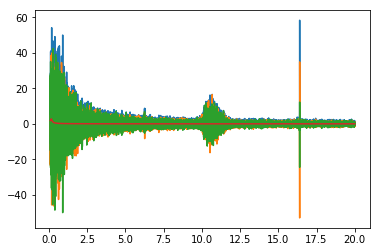

In [56]:
x = NG_FID_scan(direct)
x.read_files()
x.sort_names()
#plt.xlim(6.4,6.6)
x.fit_FID(i = 1, show_curr = 'True',show_fit_width = 'True', show_plots = 'True', phi = 0, gamma = 1e-2,
          phase_guessing = 'Falase');

-8000.0


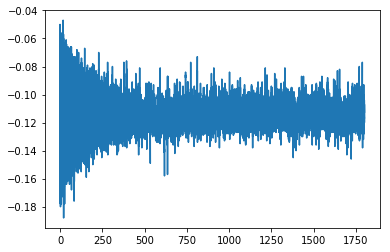

In [57]:
x.show_data()

-8000.0


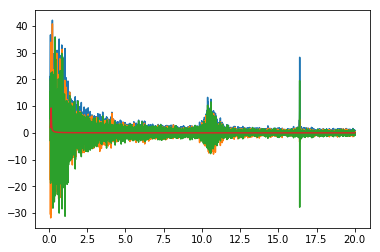

-7484.0


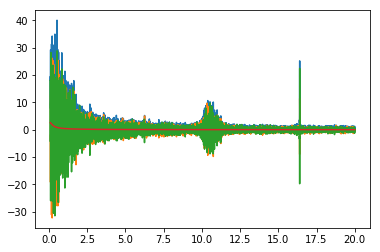

-6968.0


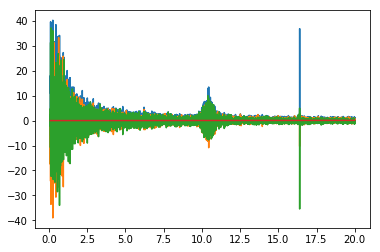

-6451.0


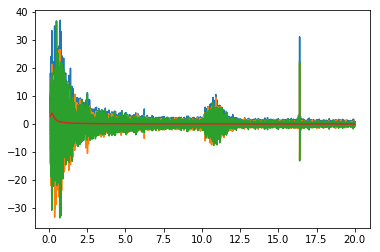

-5935.0


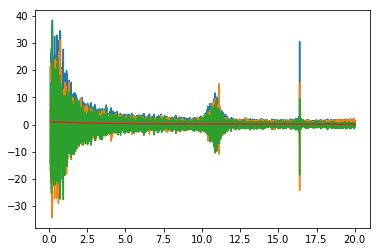

-5419.0


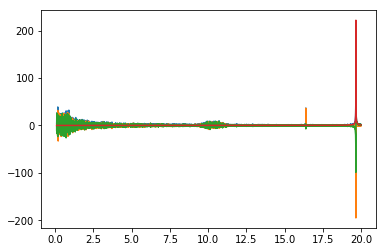

-4904.0


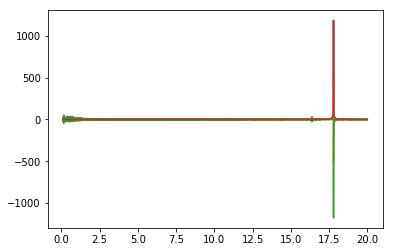

-4388.0


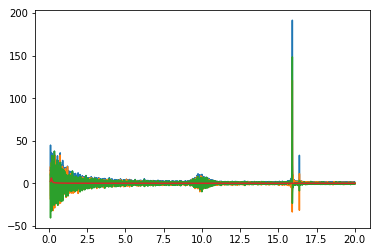

-3871.0


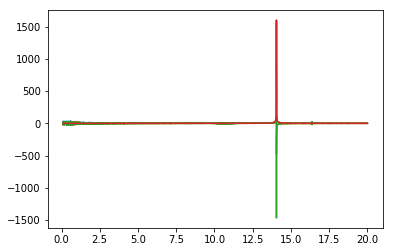

-3355.0


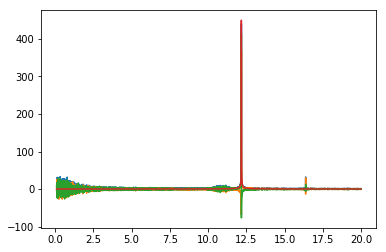

-2839.0


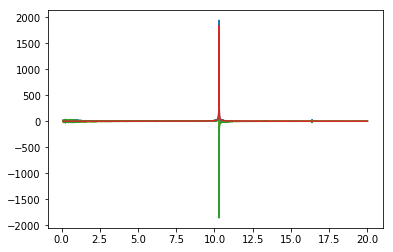

-2323.0


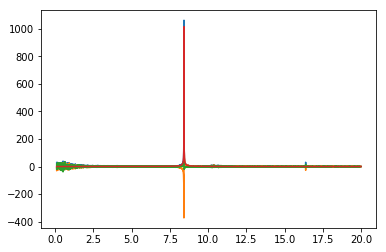

-1806.0


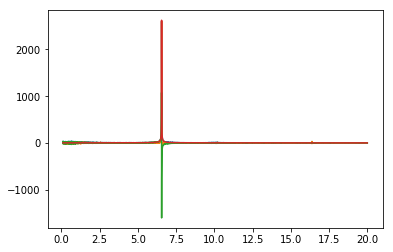

-1290.0


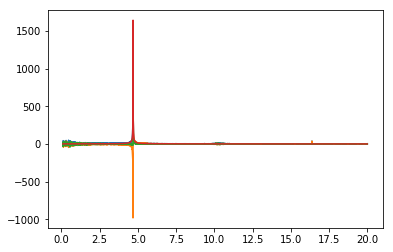

-774.0


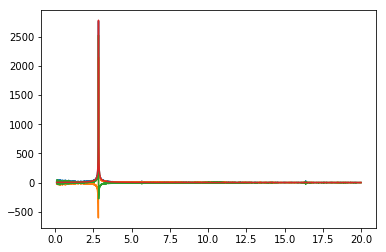

-258.0


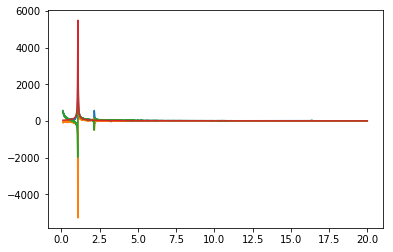

258.0


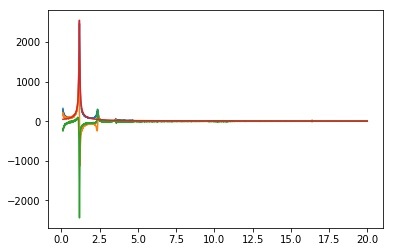

774.0


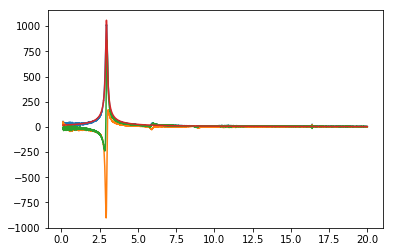

1290.0


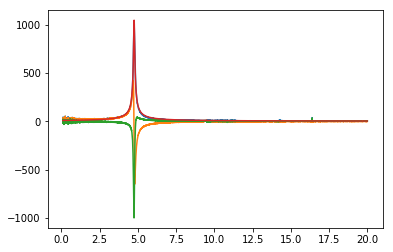

1806.0


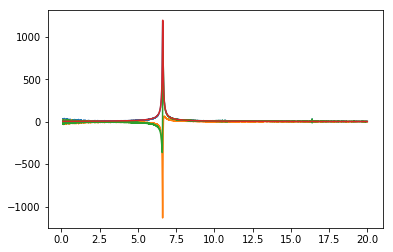

2323.0


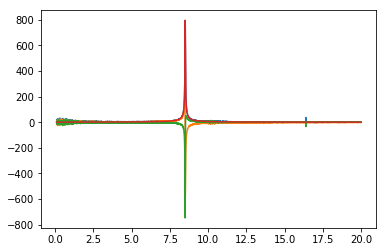

2839.0


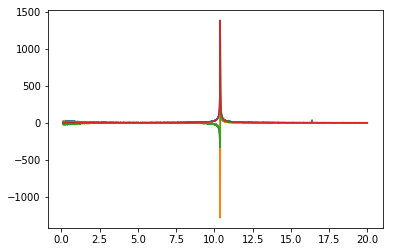

3355.0


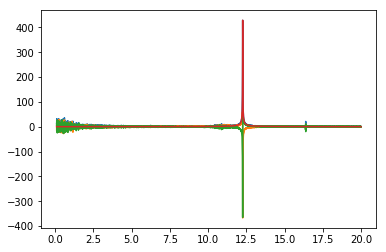

3871.0


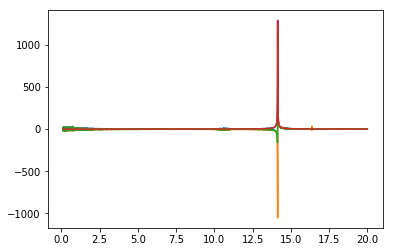

4388.0


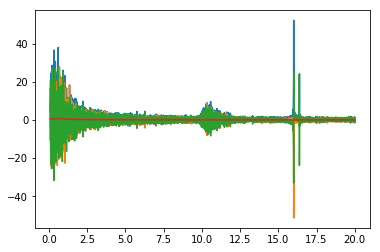

4904.0


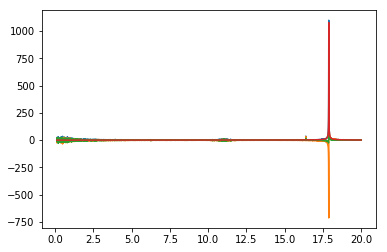

5419.0


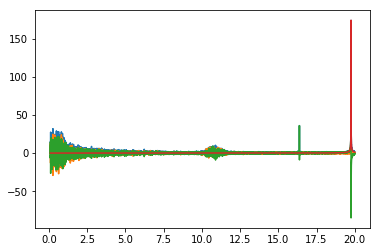

5935.0


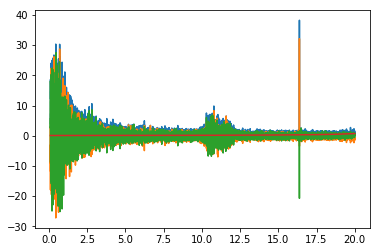

6451.0


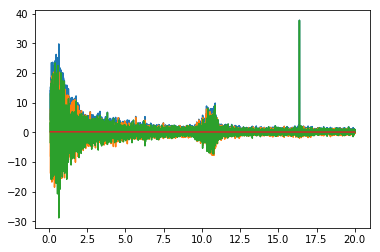

6968.0


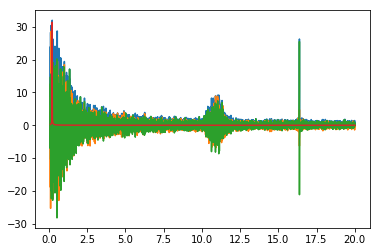

7484.0


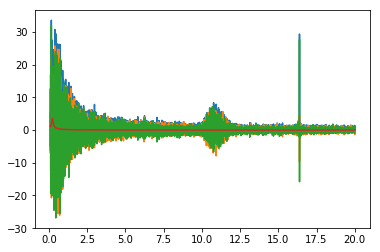

8000.0


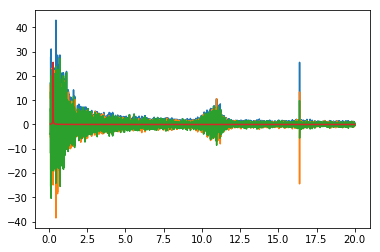

In [65]:
x.fit_all_FID( phi = np.pi, gamma = 1e-1, b = 90000)

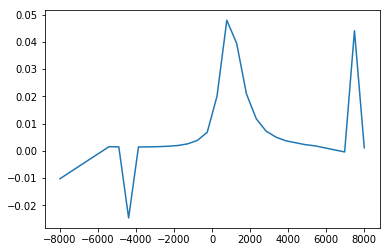

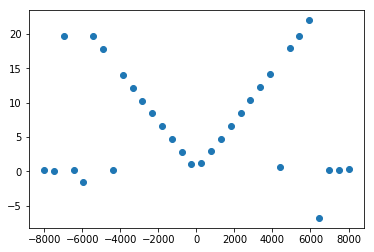

In [74]:
ar = np.array(x.fit_width)
c_ar = np.array(x.curr)
ind = np.where(abs(ar) < 0.1)
#plt.xlim(0,2000)
plt.plot(c_ar[ind], ar[ind])
plt.show()
#plt.xlim(-1000,2500)
plt.plot(x.curr, x.fit_freq, 'o')

-8000.0
89950
44976


ValueError: x and y must have same first dimension, but have shapes (44976,) and (89950,)

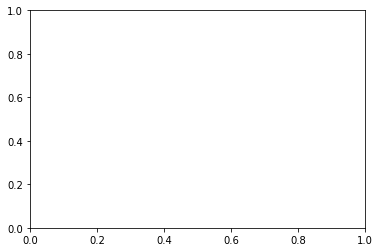

In [64]:
x.show_fft()

-8000.0


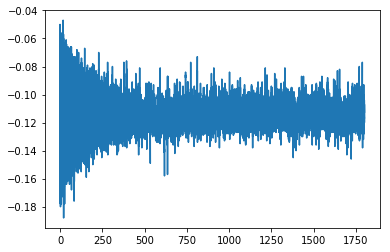

-7484.0


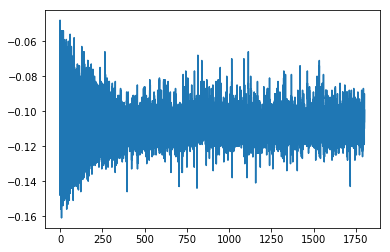

-6968.0


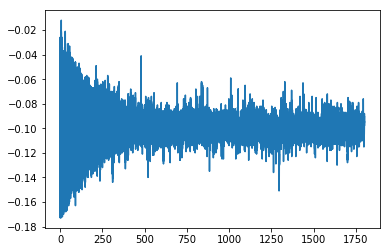

-6451.0


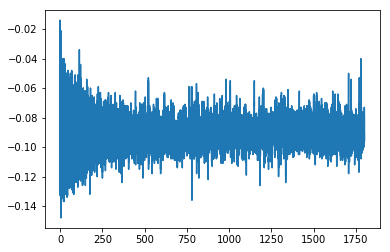

-5935.0


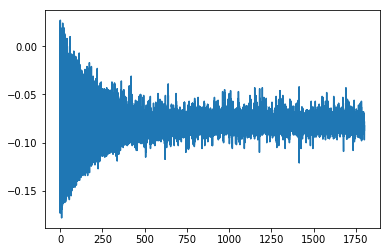

-5419.0


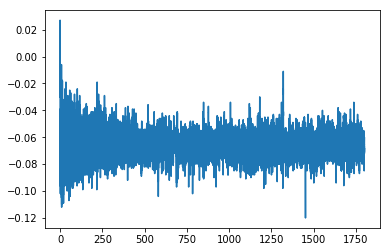

-4904.0


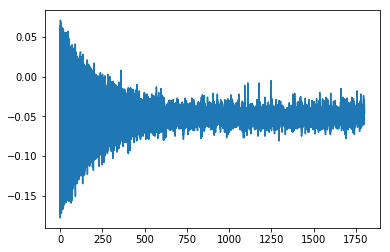

-4388.0


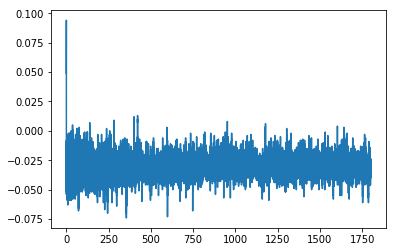

-3871.0


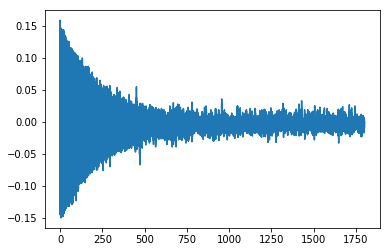

-3355.0


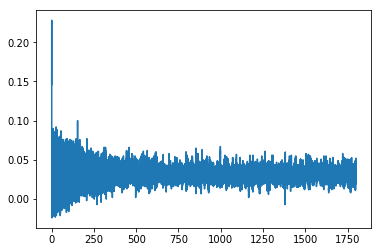

-2839.0


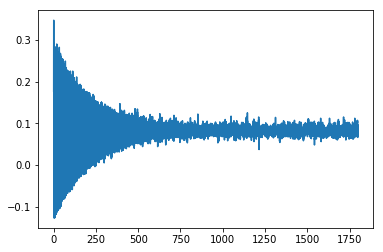

-2323.0


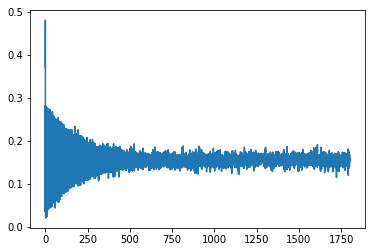

-1806.0


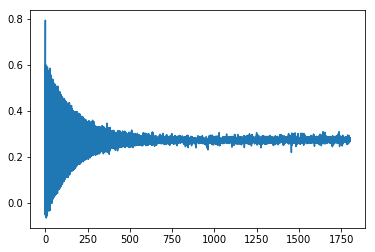

-1290.0


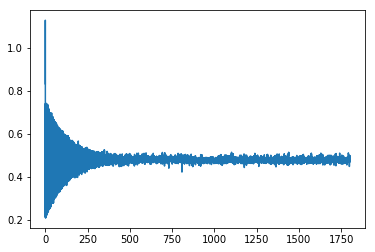

-774.0


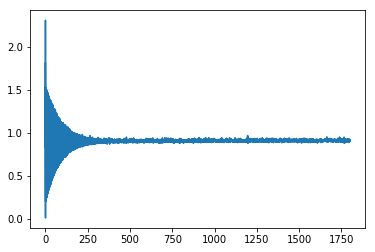

-258.0


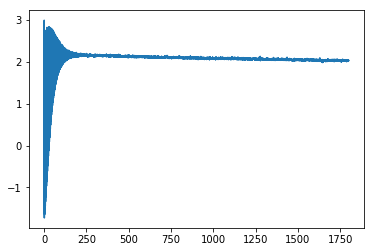

258.0


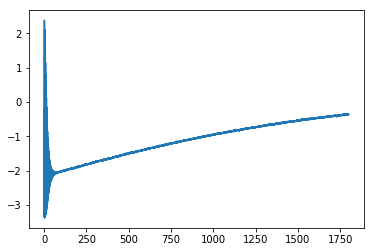

774.0


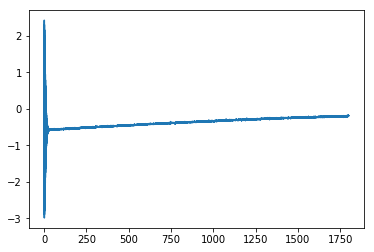

1290.0


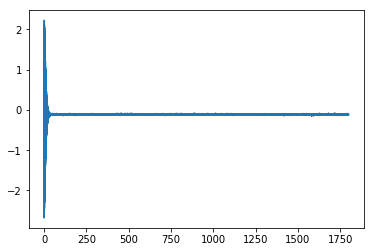

1806.0


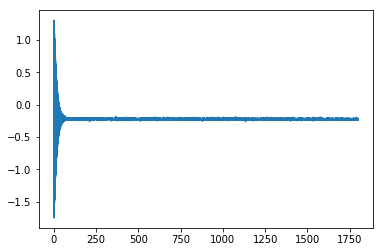

2323.0


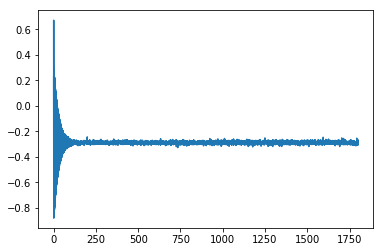

2839.0


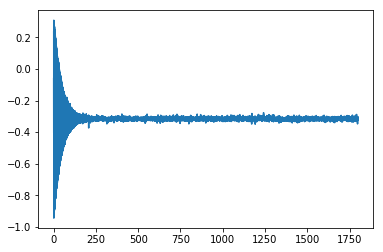

3355.0


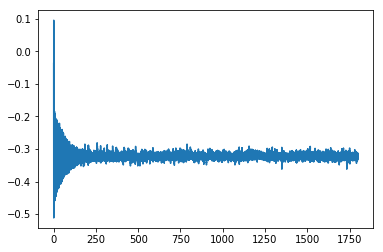

3871.0


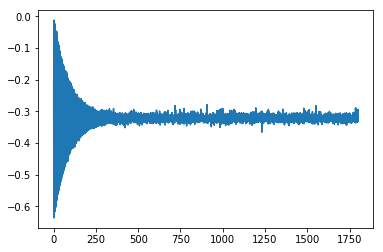

4388.0


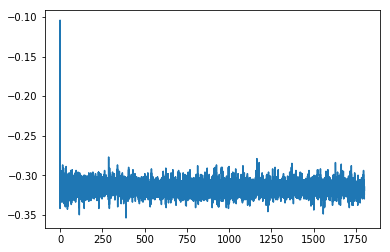

4904.0


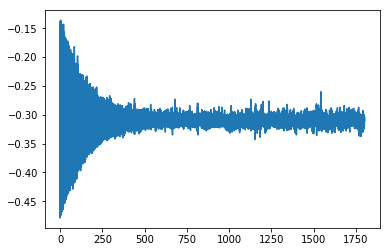

5419.0


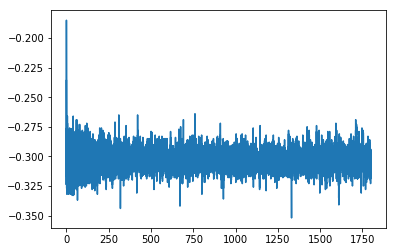

5935.0


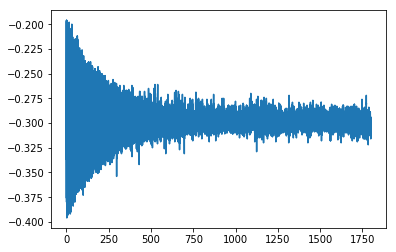

6451.0


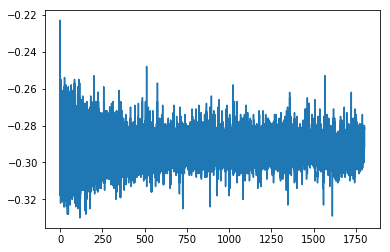

6968.0


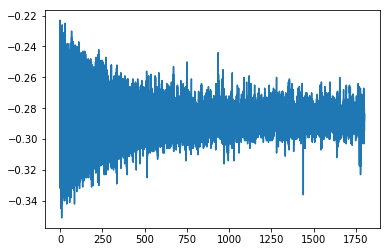

7484.0


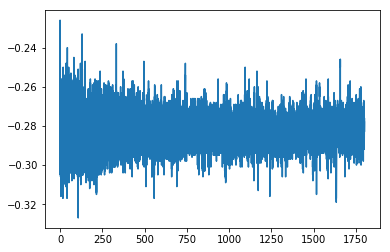

8000.0


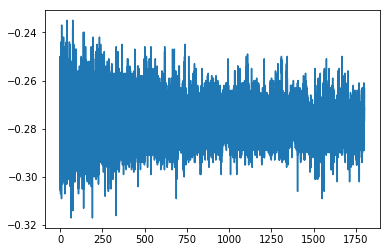

In [38]:
x.show_all_data()

In [10]:
direct = 'SERF resonances on new cell/After degaussing/t2_he_wide_scan/'

-8000.0
He res width =  0.7959564279742786


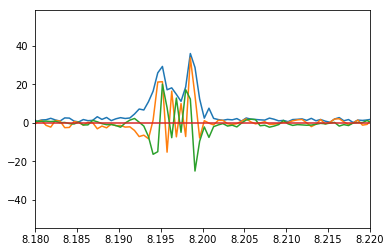

In [11]:
x = NG_FID_scan(direct)
x.read_files()
x.sort_names()
plt.xlim(8.18,8.22)
x.fit_FID(show_curr = 'True',show_fit_width = 'True', show_plots = 'True');

774.0


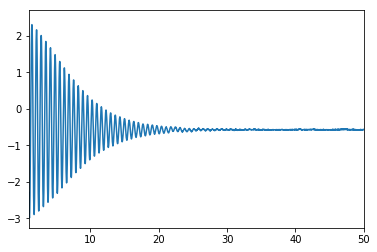

In [18]:
plt.xlim(1,50)
x.show_data(i = 17)

-8000.0


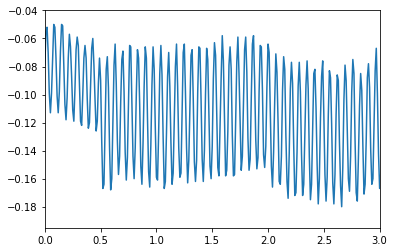

-7484.0


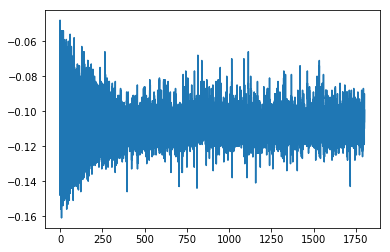

-6968.0


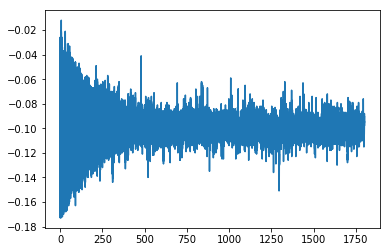

-6451.0


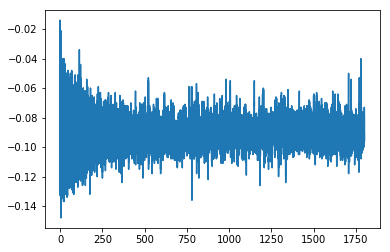

-5935.0


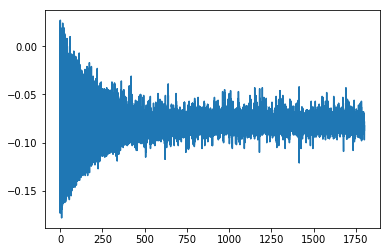

-5419.0


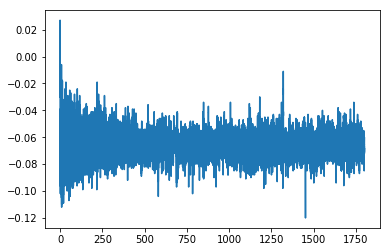

-4904.0


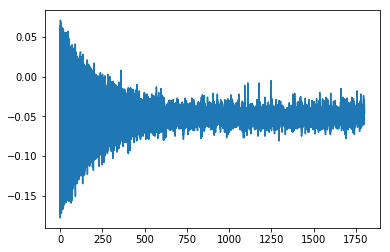

-4388.0


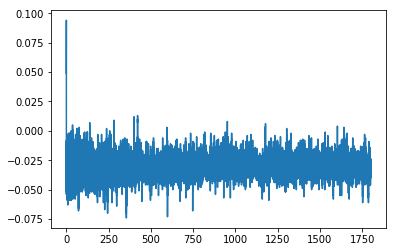

-3871.0


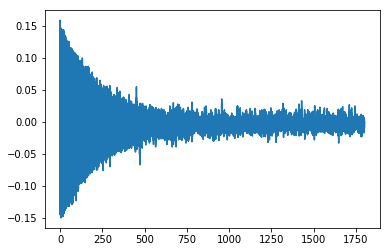

-3355.0


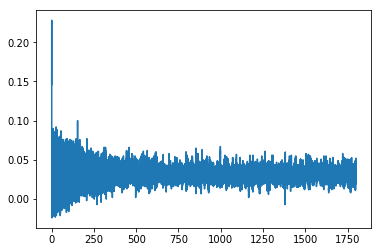

-2839.0


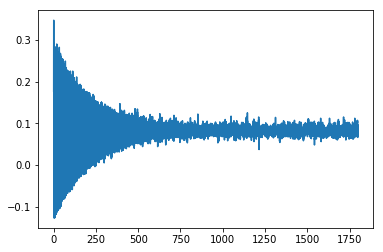

-2323.0


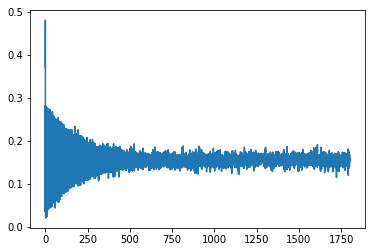

-1806.0


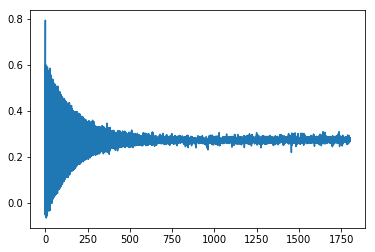

-1290.0


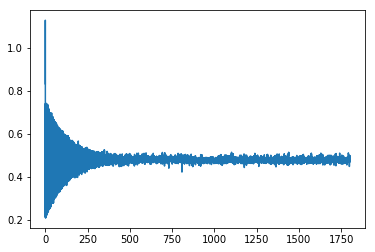

-774.0


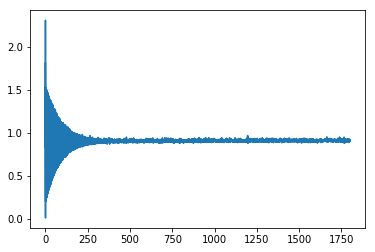

-258.0


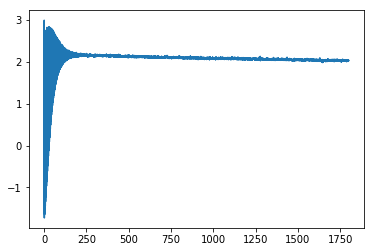

258.0


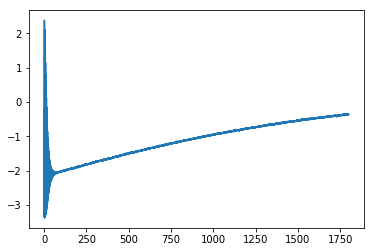

774.0


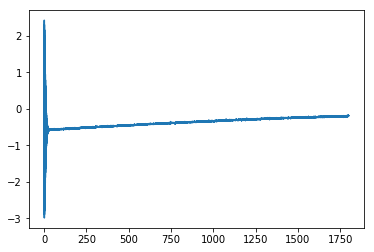

1290.0


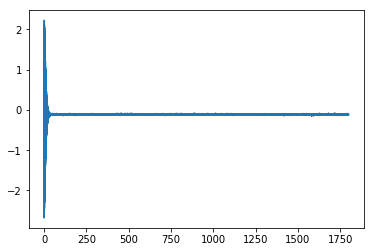

1806.0


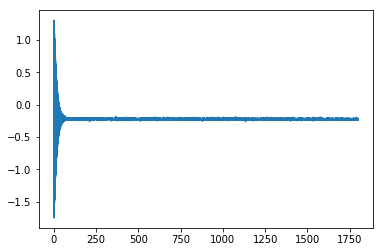

2323.0


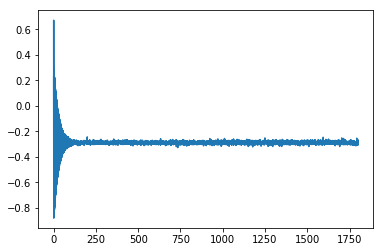

2839.0


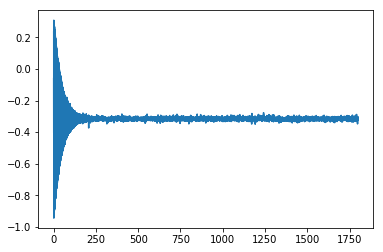

3355.0


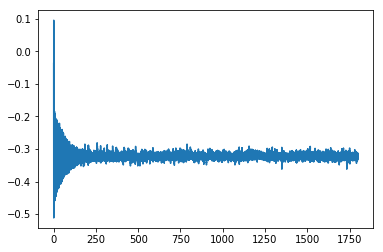

3871.0


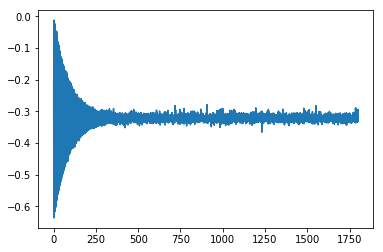

4388.0


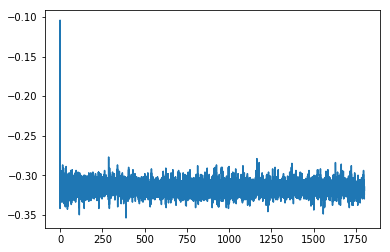

4904.0


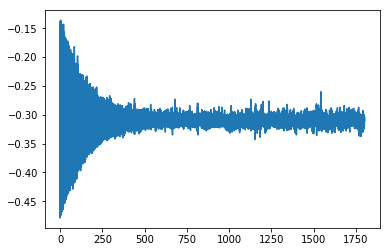

5419.0


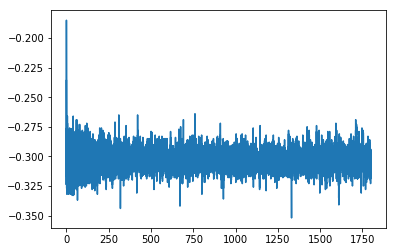

5935.0


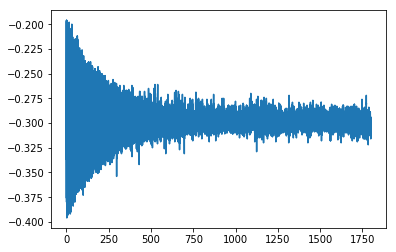

6451.0


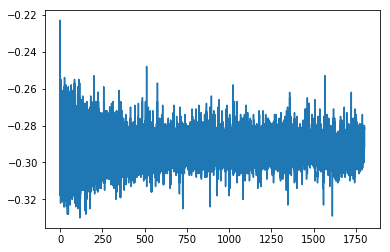

6968.0


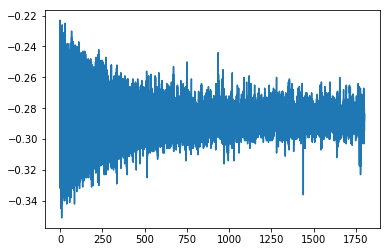

7484.0


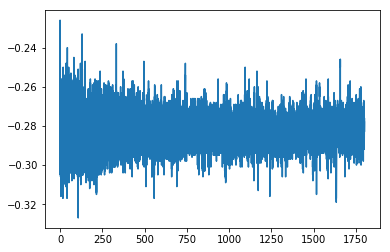

8000.0


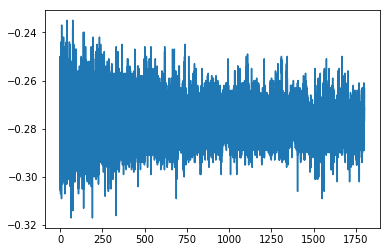

In [19]:
plt.xlim(0,3)
x.show_all_data()

-4000.0


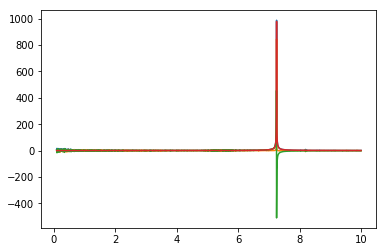

-3600.0


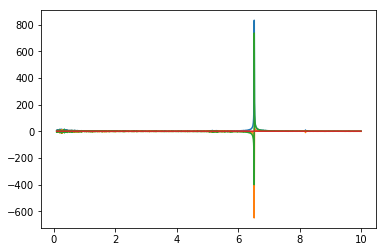

-3200.0


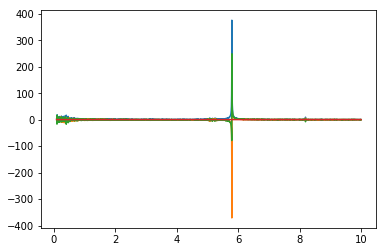

-2800.0


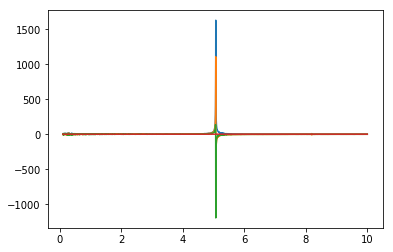

-2400.0


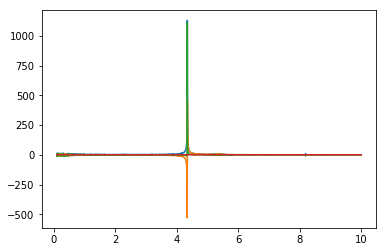

-2000.0


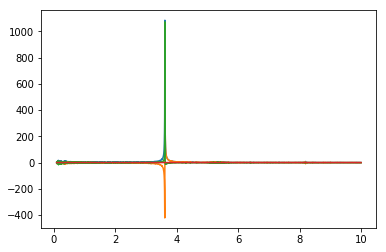

-1600.0


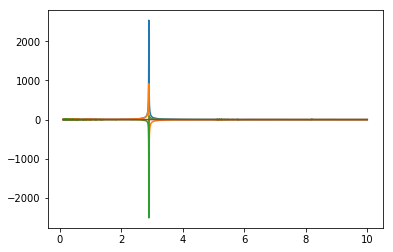

-1200.0


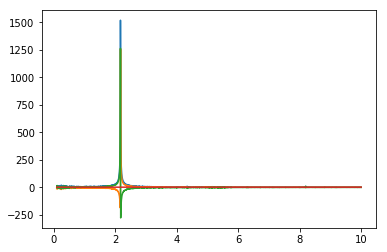

-800.0


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

In [128]:
x.fit_all_FID()

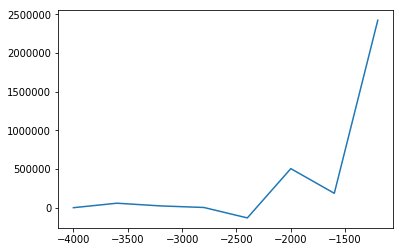

In [123]:
plt.plot(x.curr, x.fit_freq)

In [84]:
#search for filenames

file_names = glob.glob(direct+"*.dat")

file_names = file_names
file_names

['SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-1200_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-1600_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-2000_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-2400_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-2800_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-3200_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-3600_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-4000_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-400_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_-800_uA.dat',
 'SERF resonances on new cell/After degaussing/t2_he\\Ch_1_Curr_0_uA.dat']

In [6]:
x = FID_out(file_names[0])
x.load_data()

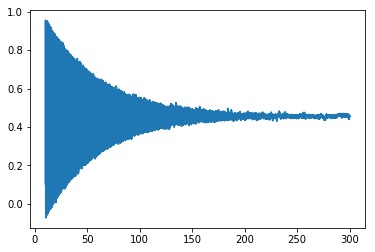

In [7]:
plt.plot(x.data[1000:,0],x.data[1000:,1])

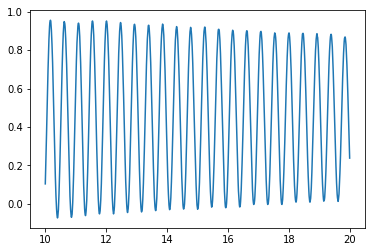

In [8]:
plt.plot(x.data[1000:2000,0],x.data[1000:2000,1])

-1200.0
He res width =  0.003090261470802359


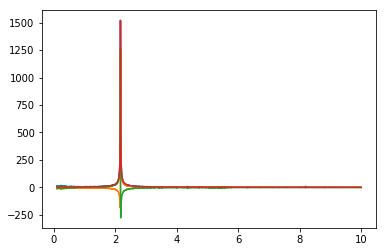

-1600.0
He res width =  0.0025316773491519257


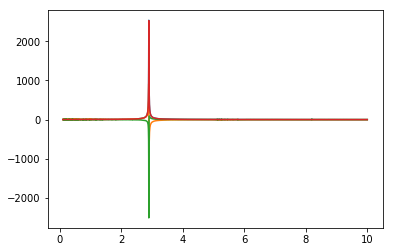

-2000.0
He res width =  0.0022339610407108245


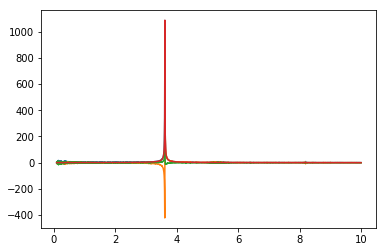

-2400.0
He res width =  0.001972515790821873


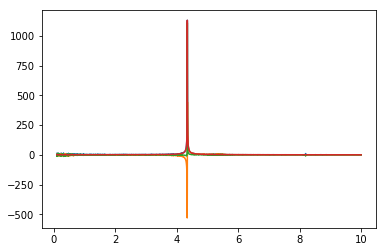

-2800.0
He res width =  0.0017902379571365095


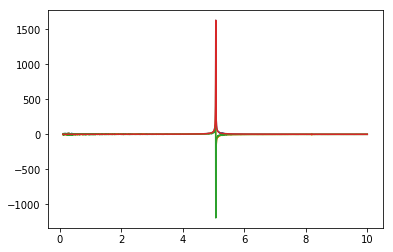

-3200.0
He res width =  0.0016627644589223797


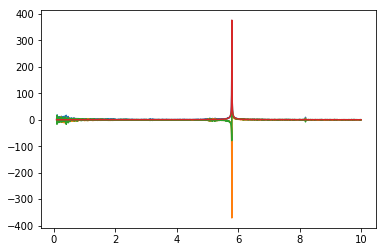

-3600.0
He res width =  0.0015524769053043106


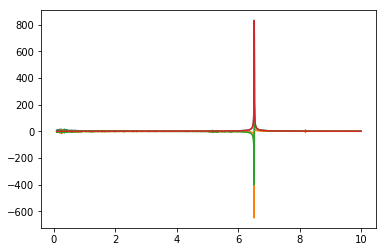

-4000.0
He res width =  -0.0015571616986702886


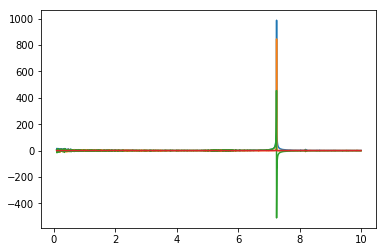

-400.0
He res width =  0.0041440927026855385


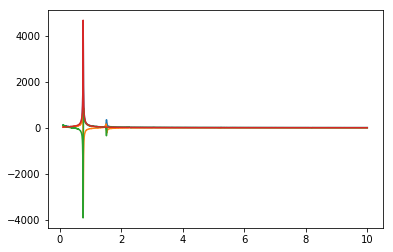

-800.0
He res width =  0.0038151268938172948


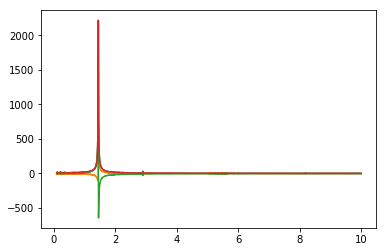

0.0
He res width =  0.08749431958269789


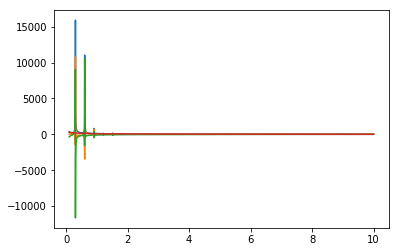

0.0
He res width =  0.004146457612728413


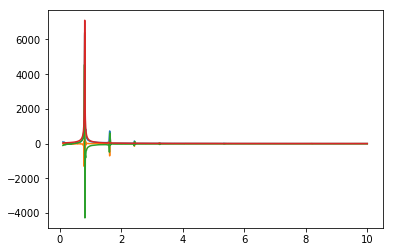

800.0
He res width =  0.010910448344775824


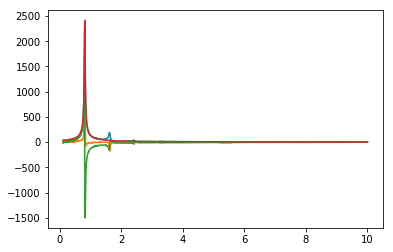

In [23]:
for fn in file_names: 
    x = FID_out(fn)
    print(x.curr)
    x.load_data()
    x.comp_fft(a = 101, b = -1)
    x.find_ind()
    x.find_ind()
    popt, pcov = x.lorentzian_fit(f = 2.6,gamma = 1e-3,phi = 3*np.pi/4)
    print('He res width = ', popt[2])
    plt.plot(x.freq_fit,np.abs(x.fft_fit))
    plt.plot(x.freq_fit,np.real(x.fft_fit))
    plt.plot(x.freq_fit,np.imag(x.fft_fit))
    plt.plot(x.freq_fit,np.abs(complex_lorentz(x.freq_fit,*popt)))
    #plt.plot(f_span,np.real(complex_lorentz(f_span,*popt)))
    #plt.plot(f_span,np.imag(complex_lorentz(f_span,*popt)))
    #plt.xlim(3.0,3.5)
    plt.show()



# 160 deg

In [49]:
direct = 'SERF resonances on new cell/After degaussing/160_c/T_2_measurement_new_program/'

-7568.0
He res width =  0.0022902921161312992


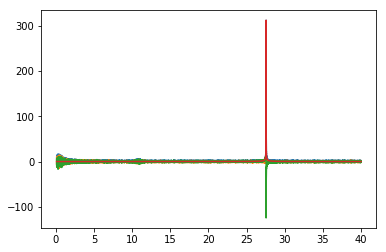

In [50]:
x = NG_FID_scan(direct)
x.read_files()
x.sort_names()
#plt.xlim(6.4,6.6)
x.fit_FID(i = 1,show_curr = 'True',show_fit_width = 'True', show_plots = 'True', phi = 0, gamma = 1e-2,
          phase_guessing = 'Falase');

-8000.0


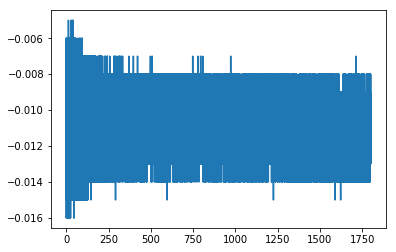

-7568.0


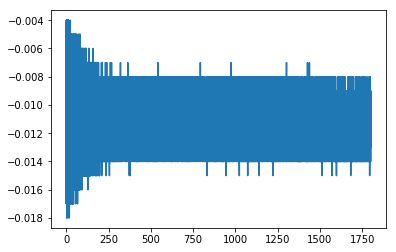

-7135.0


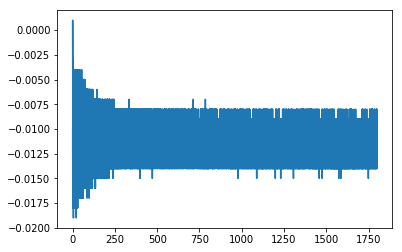

-6702.0


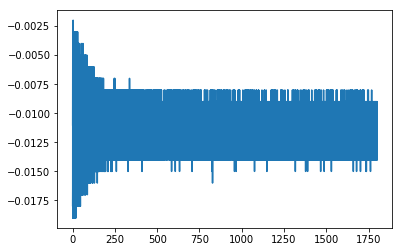

-6270.0


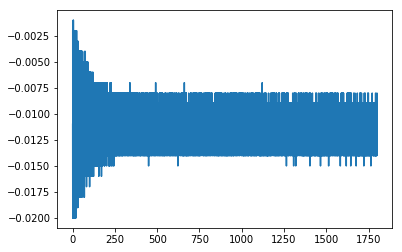

-5838.0


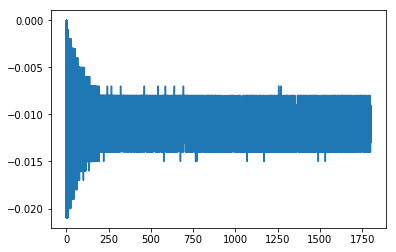

-5405.0


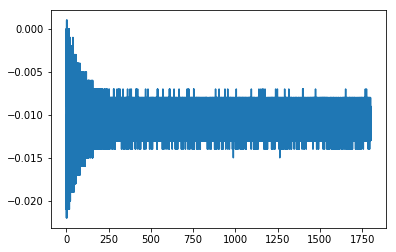

-4972.0


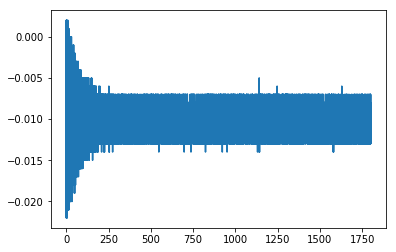

-4540.0


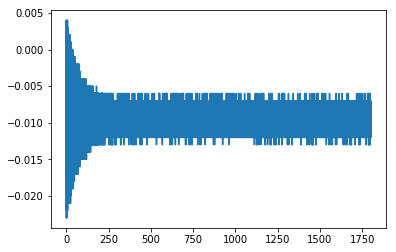

-4108.0


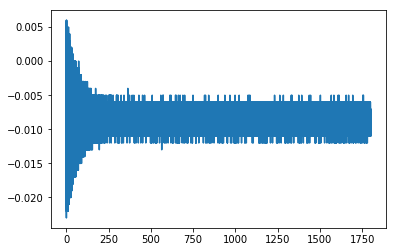

-3676.0


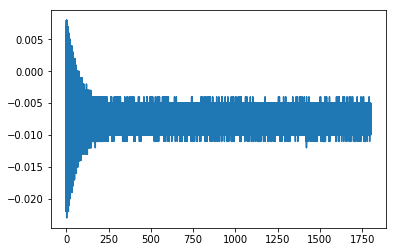

-3243.0


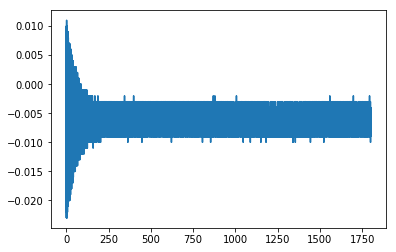

-2811.0


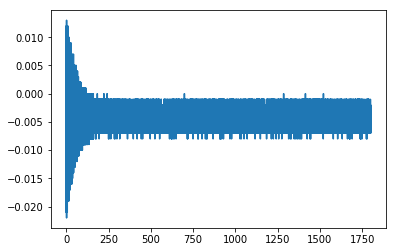

-2378.0


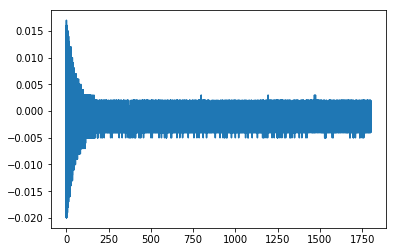

-1946.0


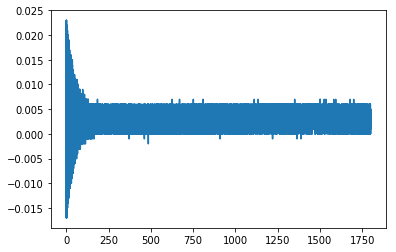

-1514.0


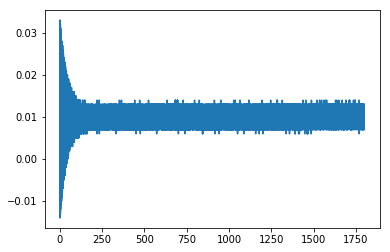

-1081.0


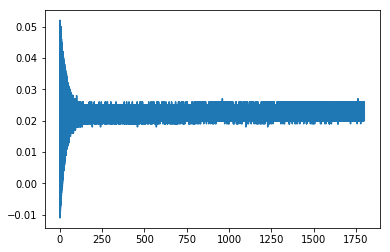

-649.0


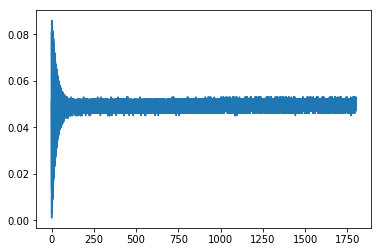

-216.0


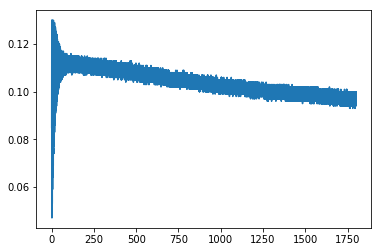

216.0


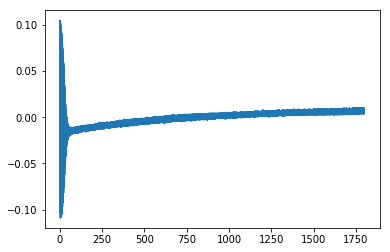

649.0


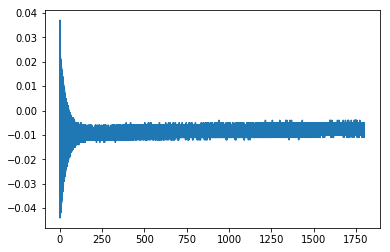

1081.0


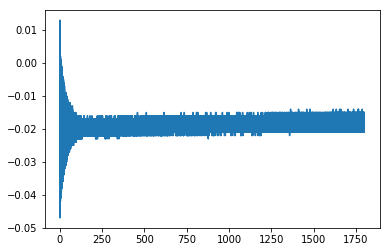

1514.0


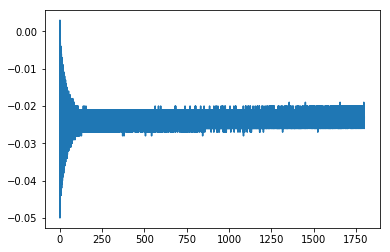

1946.0


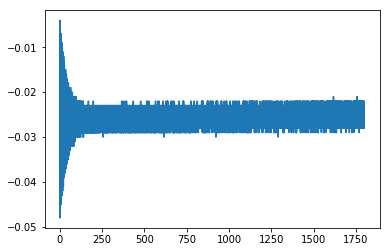

2378.0


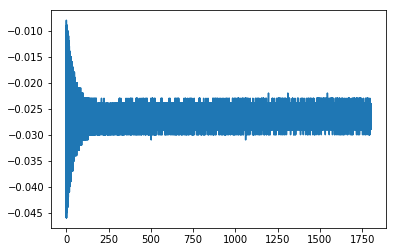

2811.0


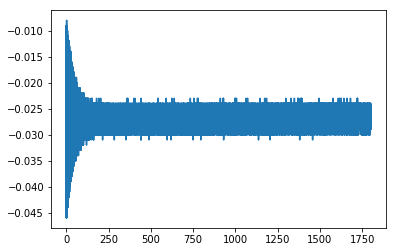

3243.0


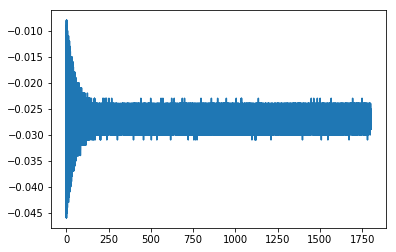

3676.0


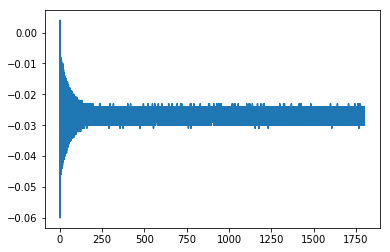

4108.0


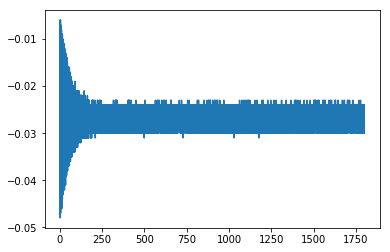

4540.0


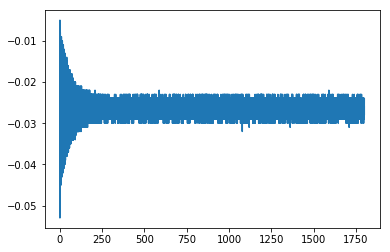

4972.0


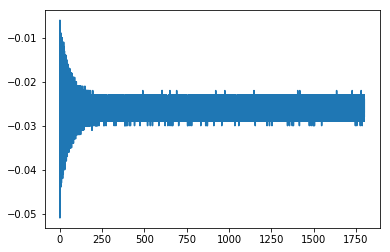

5405.0


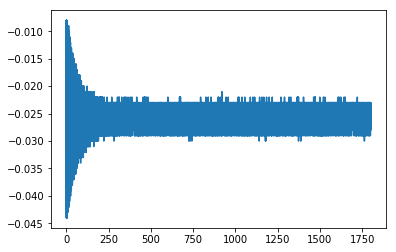

5838.0


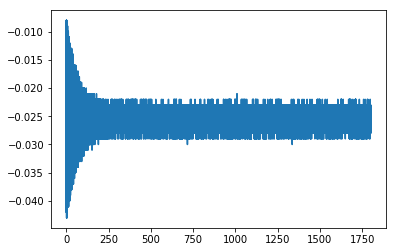

6270.0


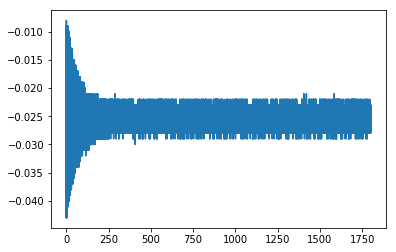

6702.0


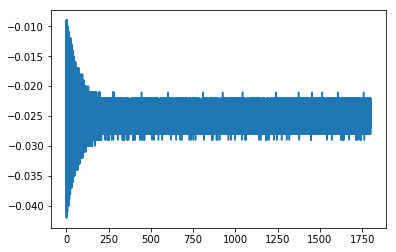

7135.0


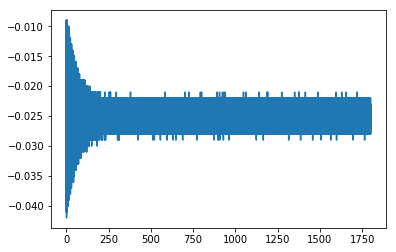

7568.0


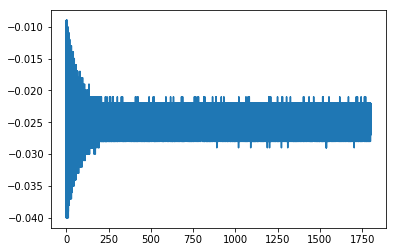

In [51]:
x.show_all_data()

-8000.0


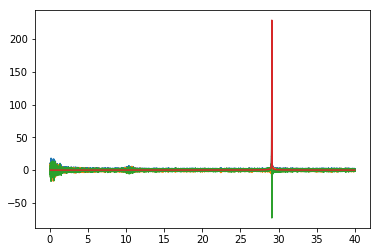

-7568.0


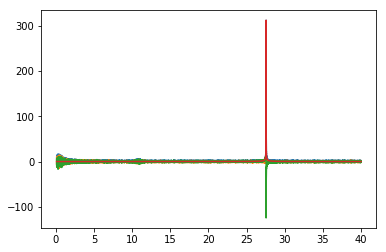

-7135.0


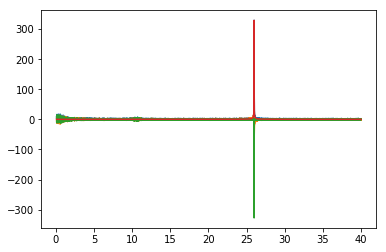

-6702.0


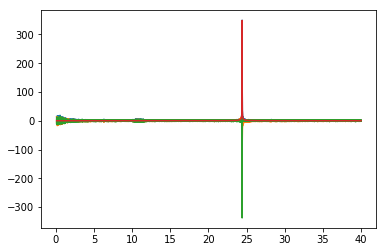

-6270.0


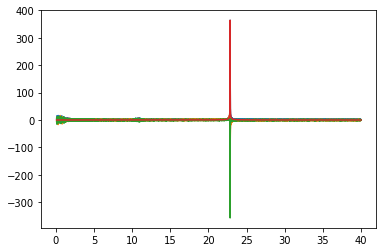

-5838.0


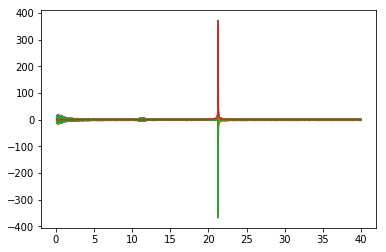

-5405.0


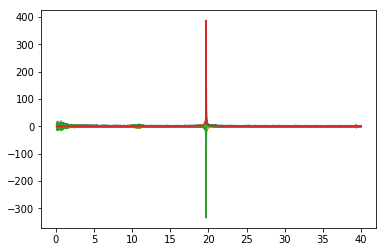

-4972.0


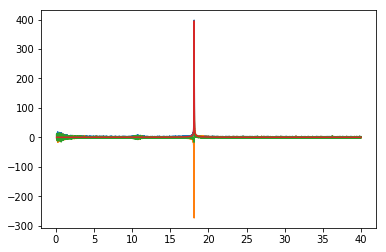

-4540.0


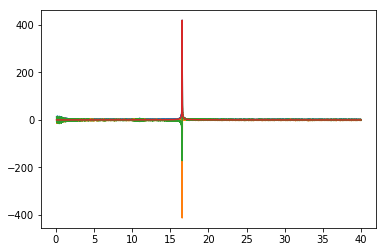

-4108.0


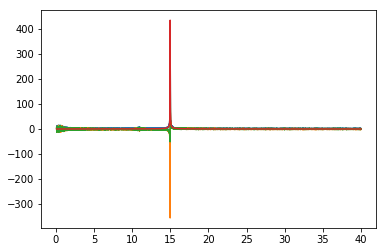

-3676.0


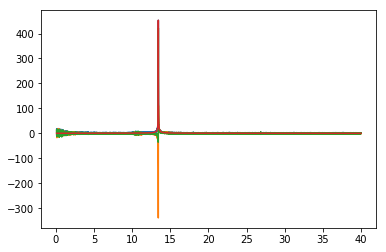

-3243.0


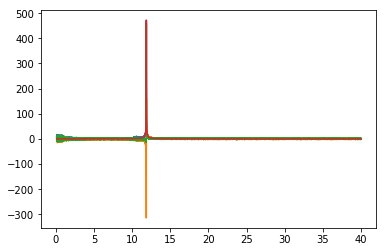

-2811.0


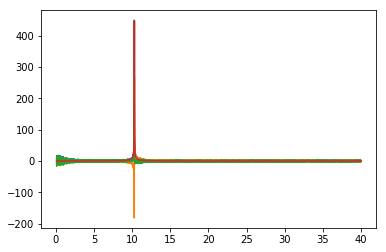

-2378.0


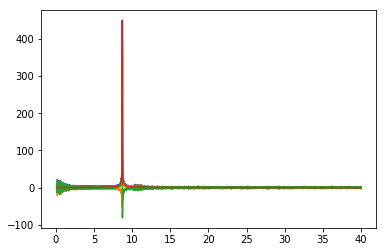

-1946.0


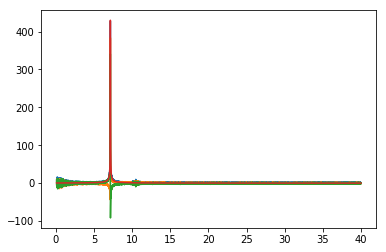

-1514.0


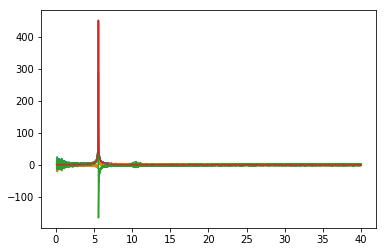

-1081.0


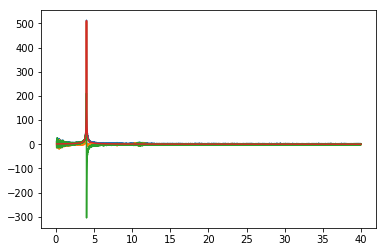

-649.0


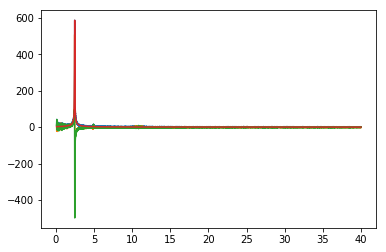

-216.0


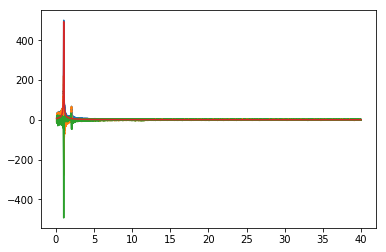

216.0


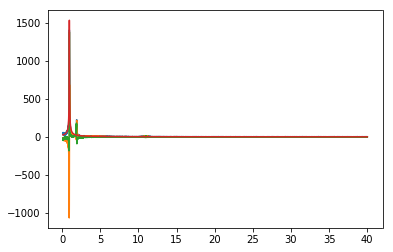

649.0


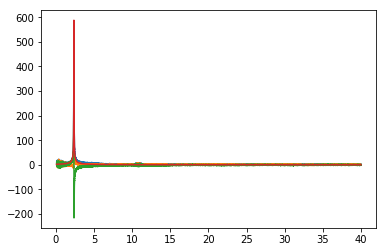

1081.0


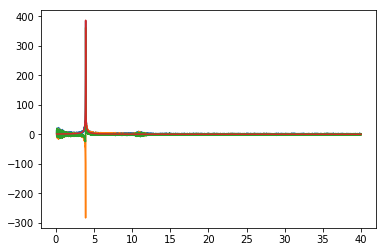

1514.0


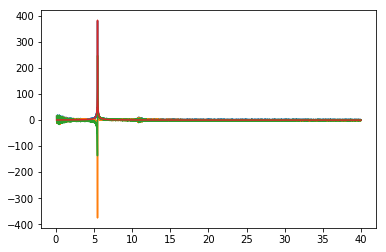

1946.0


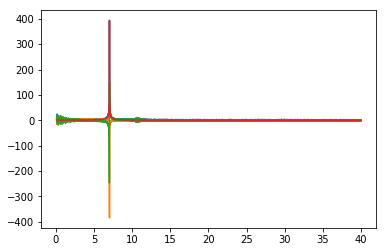

2378.0


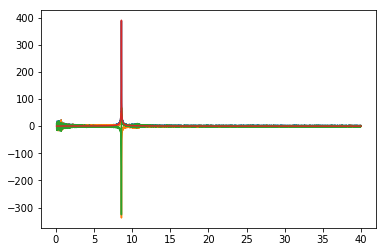

2811.0


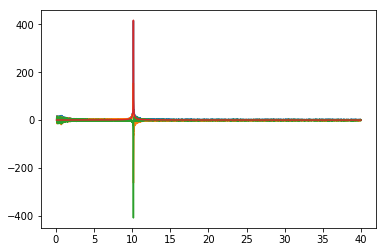

3243.0


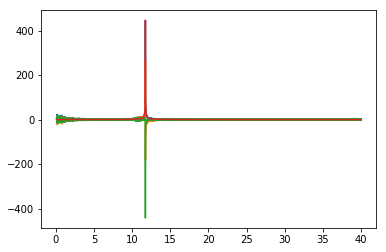

3676.0


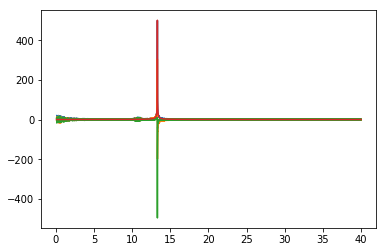

4108.0


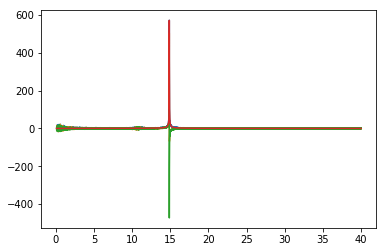

4540.0


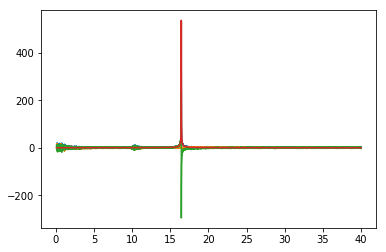

4972.0


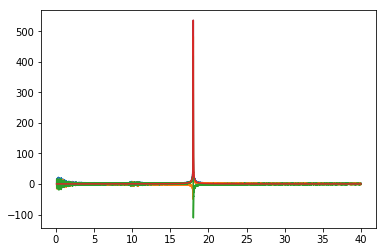

5405.0


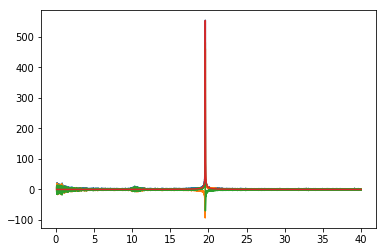

5838.0


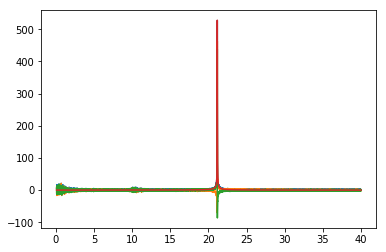

6270.0


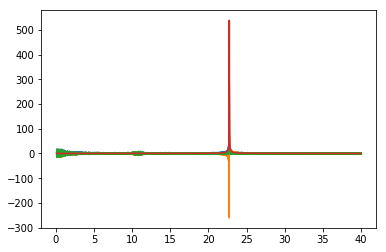

6702.0


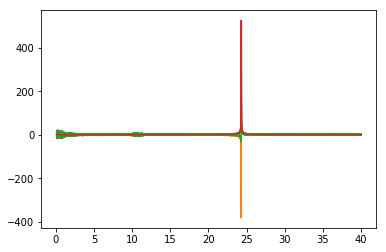

7135.0


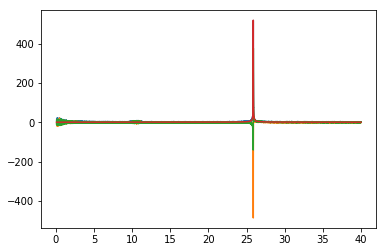

7568.0


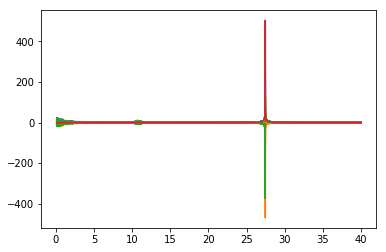

In [52]:
x.fit_all_FID()

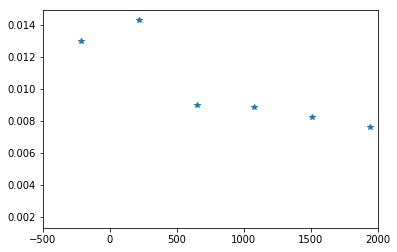

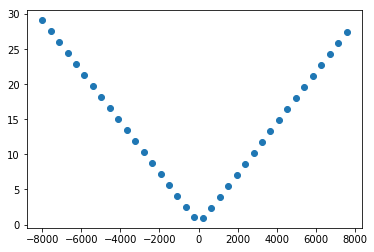

In [54]:
ar = np.array(x.fit_width)
c_ar = np.array(x.curr)
ind = np.where(abs(ar) < 0.1)
plt.xlim(-500,2000)
plt.plot(c_ar[ind], ar[ind],'*')
plt.show()
#plt.xlim(-1000,2500)
plt.plot(x.curr, x.fit_freq, 'o')

# Steop-like modulation

In [33]:
direct = 'SERF resonances on new cell/After degaussing/160_c/Step change of the field/'

In [34]:
x = NG_FID_scan(direct)
x.read_files()
x.sort_names()
#plt.xlim(6.4,6.6)


-2000.0


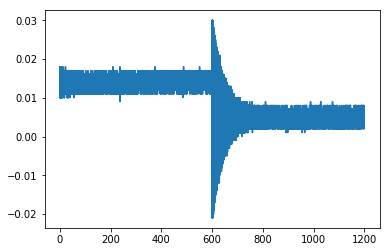

-1897.0


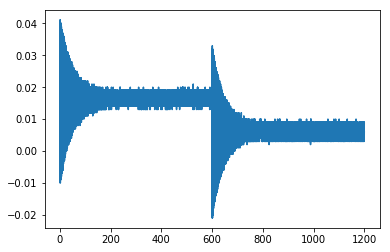

-1795.0


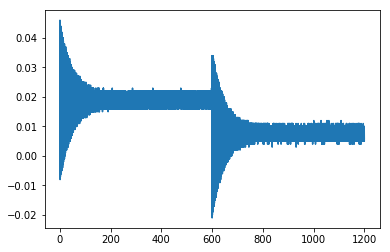

-1692.0


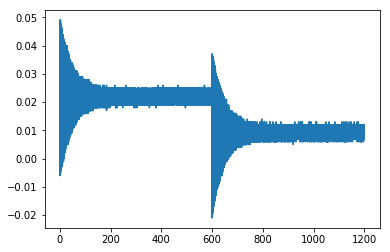

-1590.0


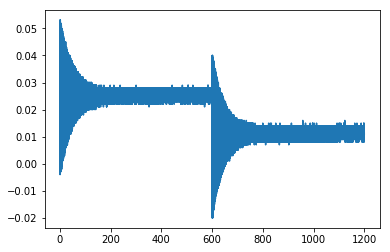

-1487.0


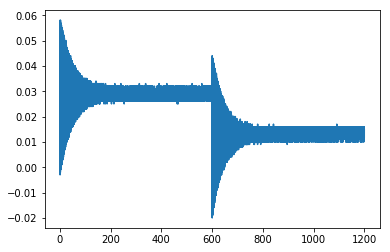

-1385.0


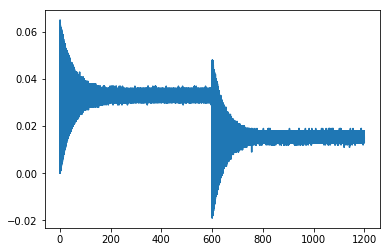

-1282.0


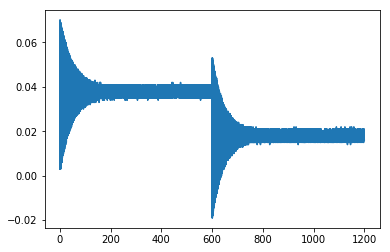

-1180.0


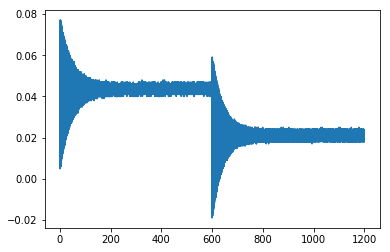

-1077.0


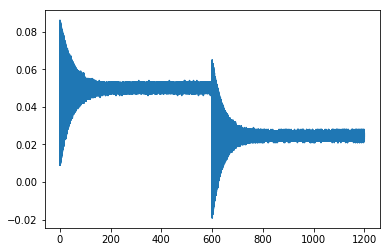

-974.0


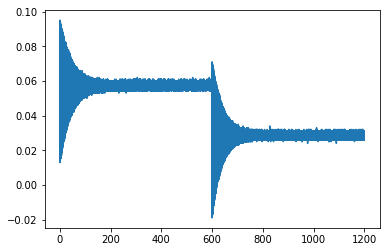

-872.0


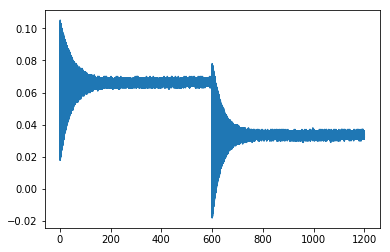

-769.0


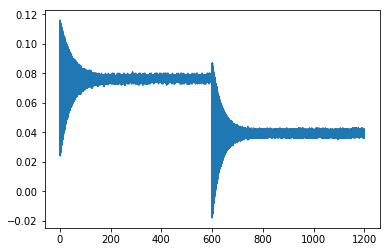

-667.0


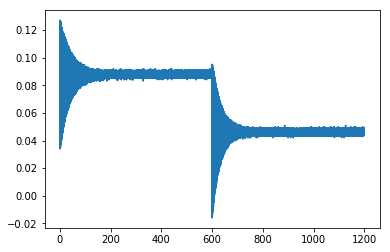

-564.0


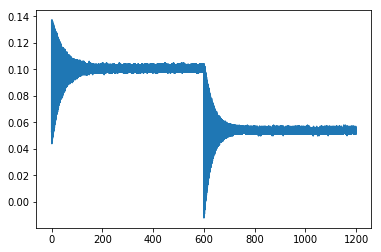

-462.0


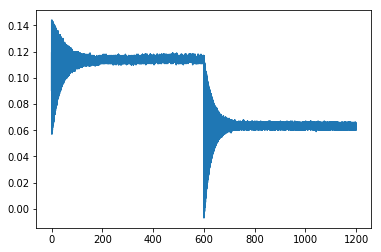

-359.0


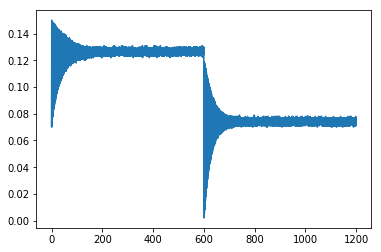

-256.0


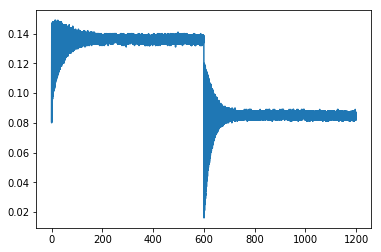

-154.0


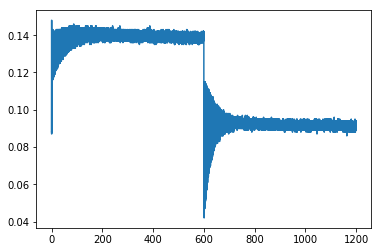

-51.0


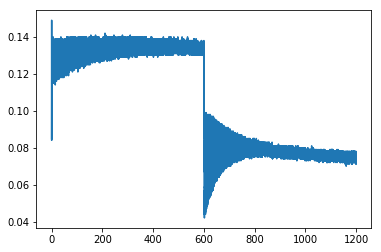

51.0


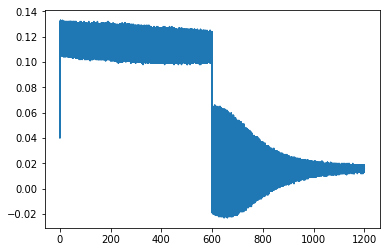

154.0


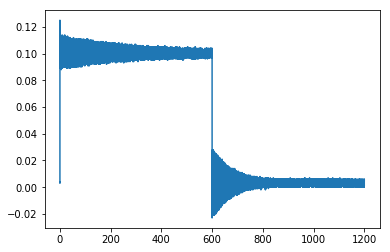

256.0


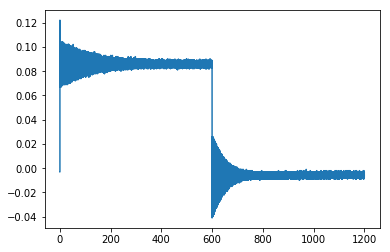

359.0


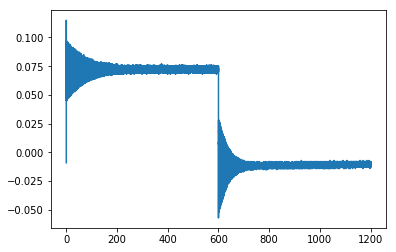

462.0


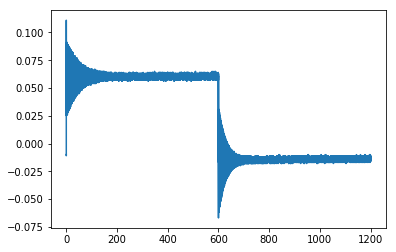

564.0


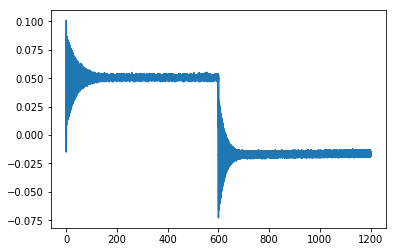

667.0


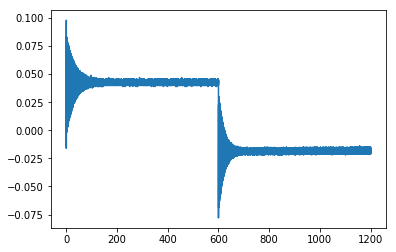

769.0


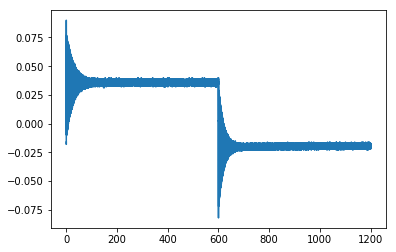

872.0


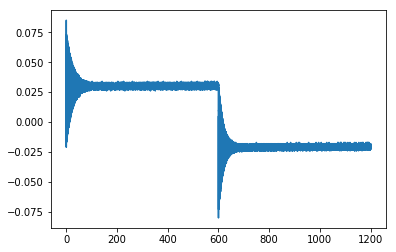

974.0


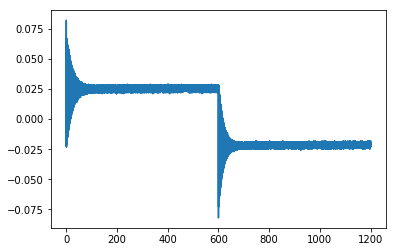

1077.0


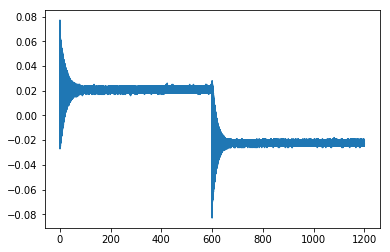

1180.0


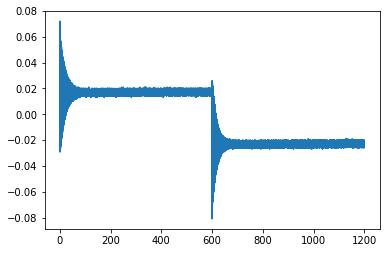

1282.0


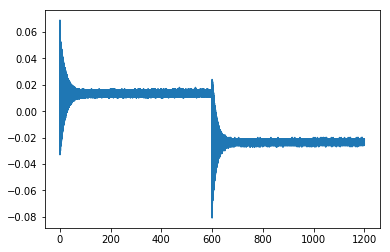

1385.0


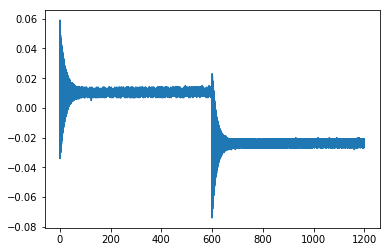

1487.0


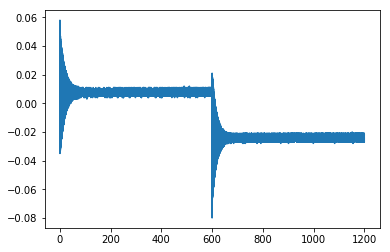

1590.0


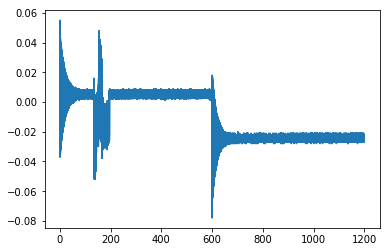

1692.0


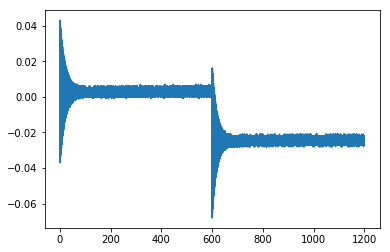

1795.0


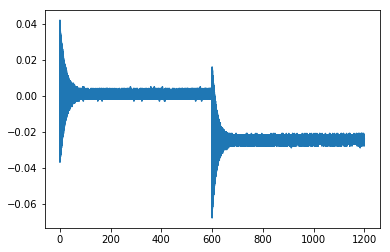

1897.0


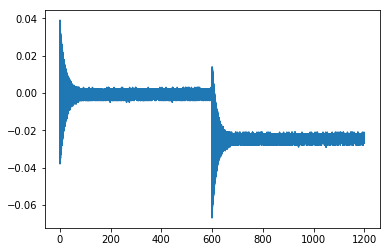

In [35]:
x.show_all_data()

-1897.0
He res width =  0.006868199927677453


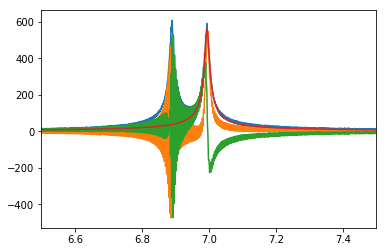

In [47]:
plt.xlim(6.5,7.5)
x.fit_FID(i = 1,show_curr = 'True',show_fit_width = 'True', show_plots = 'True', phi = 0, gamma = 1e-2,
          phase_guessing = 'Falase');

In [40]:
file_names = glob.glob(direct+'/*.dat')
file_names;

In [42]:
y = FID_out(file_names[0])
y.load_data()

In [43]:
len(y.data)

1200000